## Topic Modeling: LDA

### Include all the dependencies

In [1]:
from pymongo import MongoClient

import pandas as pd
import numpy as np

!pip install gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pd.options.display.max_colwidth = 200
import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


### Import Clean Data

In [32]:
# import the clean articles, you can load it from data/articles_processed.csv instead
client = MongoClient('mongodb://localhost:27017')
db = client.bbcnews
articles_processed = db.articles_processed
articles = pd.DataFrame(list(articles_processed.find()))
articles.head()

,_id,url,date,menu_submenu,title,subtitle,text,n_words,article_clean,n_words_clean
0,630f9948ba4b11ac88ffd7a5,https://www.bbc.com/news/uk-england-bristol-62547754,2022-08-29 07:15:16,uk-england-bristol,Bath mother's fight for daughter's life-saving injections,The mother of a girl with a rare health condition wants her teachers to administer her life-saving medication.,"Isabella, 11, from Bath, suffers from panhypopituitarism, a defect in the pituitary gland. Her mother Kelly Park wants private training for Isabella's teachers to give her injections, after the lo...",480,isabella bath suffers panhypopituitarism defect pituitary gland mother kelly park private training isabella teacher injection local hospital hospital concern national guideline train staff park si...,176
1,630f9948ba4b11ac88ffd7a6,https://www.bbc.com/news/uk-england-gloucestershire-62685511,2022-08-29 06:34:05,uk-england-gloucestershire,Bourton-on-the-Water tourism charge raises £62k,"A tourism charge introduced in a popular Cotswold village in response to the ""detrimental impact"" of visitors, has raised £62,000 for the community.",In March 2021 Cotswold District Council (CDC) began in Rissington Road car park in Bourton-on-the-Water. It was agreed by CDC cabinet as the car park is mainly used by visitors with the proceeds...,276,march cotswold district council cdc rissington road car park bourton water cdc cabinet car park mainly visitor proceeds village resident view money cdc range option measure traffic flow bicycle im...,106
2,630f9948ba4b11ac88ffd7a7,https://www.bbc.com/news/uk-england-somerset-62672249,2022-08-29 07:02:23,uk-england-somerset,Burnham's Haven Holiday park upgrade approved despite complaints,"A performance stage and climbing wall are to be built at a holiday park, after upgrade plans were backed.","Sedgemoor District Council approved the plans for the Haven Holiday Park in Burnham-on-Sea in Somerset despite concerns about noise. Owners Haven Leisure Ltd applied to install an outdoor stage, m...",344,sedgemoor district council plan holiday park burnham sea somerset concern noise owner leisure ltd outdoor stage mini adventure playground bungee trampoline holiday park marine drive first plan fac...,125
3,630f9948ba4b11ac88ffd7a8,https://www.bbc.com/news/world-europe-62710530,2022-08-29 06:26:04,world-europe,Ukraine war: UN team leaves for Zaporizhzhia nuclear plant,"An inspection team from the UN nuclear watchdog is on its way to Ukraine's embattled Zaporizhzhia nuclear power plant, the organisation's head said.","Rafael Grossi, director general of the International Atomic Energy Agency (IAEA) said the team was expected to arrive at the plant later this week. ""We must protect the safety and security of Ukra...",389,rafael grossi director general international atomic energy agency iaea team plant later week safety security ukraine europe big nuclear facility nuclear plant russian troop march facility ukraine ...,150
4,630f9948ba4b11ac88ffd7a9,https://www.bbc.com/news/uk-england-suffolk-62687602,2022-08-29 06:29:54,uk-england-suffolk,Johnny Cash: Band in homage to cancelled 1992 Ipswich gig,"Country music star Johnny Cash was due to play a gig in Ipswich to a predicted 20,000 fans on 29 August 1992. It was abruptly cancelled days before after disappointing ticket sales. Thirty years o...","Ahead of his performance, Cash said he was looking forward to playing in ""my favourite part of England"". The legendary singer was due to play at the Suffolk Showground - since renamed Trinity Par...",487,ahead performance cash forward favourite part england legendary singer due suffolk showground trinity park poster event cash appearance nothing last minute never anniversary tribute band jax homag...,167


In [3]:
words = [text.split() for text in articles['article_clean']]

In [4]:
len(words)

20350

In [5]:
# create the term dictionary of courpus
dictionary = corpora.Dictionary(words)

# filter the least and most frequent words: filters if less than no_below, more than no_above
dictionary.filter_extremes(no_below=10, no_above=0.9) 
dictionary.compactify()

# convert list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(word) for word in words]

In [7]:
# train LDA, computing the coherence score for a range of topics
coherence_scores = []

for num_topics in range(2, 16, 2):  # experiment with many 
    
    print(f"Number of topics: ", num_topics)
    
    # create the object for LDA model using gensim library
    Lda = gensim.models.ldamulticore.LdaMulticore

    # run and train LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, 
                   num_topics=num_topics, 
                   id2word = dictionary, 
                   passes=20, 
                   chunksize = 2000, 
                   random_state=42,
                   workers=6)
    
    # compute the coherence score
    coherence_model = CoherenceModel(model=ldamodel, 
                                     texts=words, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    
    coherence_scores.append((num_topics, coherence_lda))

coherence_scores = [*zip(*coherence_scores)]

Number of topics:  2
Number of topics:  4
Number of topics:  6
Number of topics:  8
Number of topics:  10
Number of topics:  12
Number of topics:  14


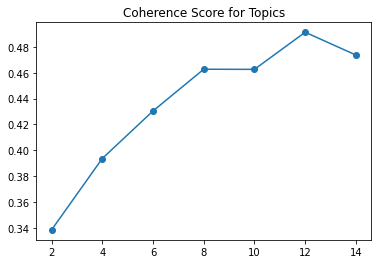

In [8]:
# plot the coherence score for topics
plt.plot(coherence_scores[0], coherence_scores[1], marker='o')
plt.title('Coherence Score for Topics')
plt.show()

In [6]:
# set the number of topics where coherence score is the highest
num_topics = 12

# run and train LDA model on the document term matrix.
Lda = gensim.models.ldamulticore.LdaMulticore

ldamodel = Lda(doc_term_matrix, 
               num_topics=num_topics, 
               id2word=dictionary, 
               passes=20, 
               chunksize=10000, 
               random_state=42,
               workers=6)

In [7]:
# view the topics with their most important words and their proportions
ldamodel.print_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.029*"council" + 0.012*"city" + 0.012*"new" + 0.009*"site" + 0.009*"year" + 0.009*"local" + 0.008*"project" + 0.008*"area" + 0.008*"plan" + 0.007*"community"'),
 (1,
  '0.017*"government" + 0.012*"ireland" + 0.011*"minister" + 0.011*"northern" + 0.010*"party" + 0.007*"law" + 0.007*"state" + 0.007*"election" + 0.007*"bill" + 0.006*"new"'),
 (2,
  '0.017*"minister" + 0.014*"johnson" + 0.013*"prime" + 0.012*"government" + 0.009*"country" + 0.008*"people" + 0.008*"airport" + 0.008*"flight" + 0.008*"year" + 0.007*"party"'),
 (3,
  '0.017*"water" + 0.015*"year" + 0.014*"price" + 0.012*"people" + 0.012*"cost" + 0.011*"energy" + 0.009*"high" + 0.008*"food" + 0.006*"month" + 0.006*"business"'),
 (4,
  '0.032*"police" + 0.017*"court" + 0.014*"year" + 0.012*"officer" + 0.010*"man" + 0.009*"old" + 0.008*"family" + 0.007*"victim" + 0.007*"investigation" + 0.006*"woman"'),
 (5,
  '0.024*"ukraine" + 0.022*"russian" + 0.018*"russia" + 0.014*"war" + 0.014*"ukrainian" + 0.008*"force" + 0.008*"c

### Visualization

For understanding the LDA plot:
    
- click a circle in the left panel to select a topic.
- the bar chart in the right panel will display the 30 most relevant terms for the selected topic.
- the red bars represent the frequency of a term in a given topic, (proportional to p(term | topic)). 
- the blue bars represent a term's frequency across the entire corpus, (proportional to p(term)). 
- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic. 
- large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.

In [8]:
ldamodel.save('lda_12.model')

In [33]:
ldamodel = gensim.models.LdaModel.load('lda_12.model')

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
#pyLDAvis.enable_notebook()

In [15]:
# visualize the intractive LDA plot
lda_display = gensim_models.prepare(ldamodel, 
                                      doc_term_matrix, 
                                      dictionary, 
                                      sort_topics=False)

In [15]:
pyLDAvis.display(lda_display)

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

In [ ]:
p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')

In [16]:
# save the plot in html format
pyLDAvis.save_html(lda_display, f"/home/ziad/projects/bbc-news/bbc-news_topics_{num_topics}.html")

### LDA as feature

Here we get the dominant topic and its proportion per document, and concatenate them with the main dataset.

In [34]:
# user inputs
corpus = doc_term_matrix
texts = articles
df = articles

In [35]:
# function to get dominant topic, percentage of contribution, and keywords for each document
def format_topics_sentences(ldamodel, corpus):

    results = []
    
    # get main topic in each document
    for row in ldamodel[corpus]:
        
        if len(row) == 0:
            continue
            
        row = list(sorted(row, key=lambda elem: elem[1], reverse=True))
        
        # get the dominant topic, percentage of contribution and keywords for each document
        topic_num, prop_topic = row[0]        
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        results.append((topic_num, round(prop_topic, 4), [topic_keywords]))
    
    df = pd.DataFrame.from_records(results, columns=['dominant_topic', 'weight', 'keywords'])
    
    return(df)

In [36]:
df_topics = format_topics_sentences(ldamodel, corpus)
df_topics.head()

,dominant_topic,weight,keywords
0,6,0.7057,"[child, people, school, year, family, life, day, time, woman, home]"
1,0,0.8561,"[council, city, new, site, year, local, project, area, plan, community]"
2,0,0.9500,"[council, city, new, site, year, local, project, area, plan, community]"
3,5,0.8273,"[ukraine, russian, russia, war, ukrainian, force, city, military, country, people]"
4,11,0.8943,"[year, people, time, first, show, world, really, event, bbc, day]"


In [37]:
df_topics['dominant_topic'].value_counts()

4     4254
0     2613
11    2564
6     1889
3     1694
8     1492
7     1165
2     1005
10     967
1      924
9      896
5      887
Name: dominant_topic, dtype: int64

In [38]:
# concatenate with the main dataset
articles = pd.concat([articles, df_topics.reindex(articles.index)], axis=1)

In [39]:
articles.head()

,_id,url,date,menu_submenu,title,subtitle,text,n_words,article_clean,n_words_clean,dominant_topic,weight,keywords
0,630f9948ba4b11ac88ffd7a5,https://www.bbc.com/news/uk-england-bristol-62547754,2022-08-29 07:15:16,uk-england-bristol,Bath mother's fight for daughter's life-saving injections,The mother of a girl with a rare health condition wants her teachers to administer her life-saving medication.,"Isabella, 11, from Bath, suffers from panhypopituitarism, a defect in the pituitary gland. Her mother Kelly Park wants private training for Isabella's teachers to give her injections, after the lo...",480,isabella bath suffers panhypopituitarism defect pituitary gland mother kelly park private training isabella teacher injection local hospital hospital concern national guideline train staff park si...,176,6,0.7057,"[child, people, school, year, family, life, day, time, woman, home]"
1,630f9948ba4b11ac88ffd7a6,https://www.bbc.com/news/uk-england-gloucestershire-62685511,2022-08-29 06:34:05,uk-england-gloucestershire,Bourton-on-the-Water tourism charge raises £62k,"A tourism charge introduced in a popular Cotswold village in response to the ""detrimental impact"" of visitors, has raised £62,000 for the community.",In March 2021 Cotswold District Council (CDC) began in Rissington Road car park in Bourton-on-the-Water. It was agreed by CDC cabinet as the car park is mainly used by visitors with the proceeds...,276,march cotswold district council cdc rissington road car park bourton water cdc cabinet car park mainly visitor proceeds village resident view money cdc range option measure traffic flow bicycle im...,106,0,0.8561,"[council, city, new, site, year, local, project, area, plan, community]"
2,630f9948ba4b11ac88ffd7a7,https://www.bbc.com/news/uk-england-somerset-62672249,2022-08-29 07:02:23,uk-england-somerset,Burnham's Haven Holiday park upgrade approved despite complaints,"A performance stage and climbing wall are to be built at a holiday park, after upgrade plans were backed.","Sedgemoor District Council approved the plans for the Haven Holiday Park in Burnham-on-Sea in Somerset despite concerns about noise. Owners Haven Leisure Ltd applied to install an outdoor stage, m...",344,sedgemoor district council plan holiday park burnham sea somerset concern noise owner leisure ltd outdoor stage mini adventure playground bungee trampoline holiday park marine drive first plan fac...,125,0,0.9500,"[council, city, new, site, year, local, project, area, plan, community]"
3,630f9948ba4b11ac88ffd7a8,https://www.bbc.com/news/world-europe-62710530,2022-08-29 06:26:04,world-europe,Ukraine war: UN team leaves for Zaporizhzhia nuclear plant,"An inspection team from the UN nuclear watchdog is on its way to Ukraine's embattled Zaporizhzhia nuclear power plant, the organisation's head said.","Rafael Grossi, director general of the International Atomic Energy Agency (IAEA) said the team was expected to arrive at the plant later this week. ""We must protect the safety and security of Ukra...",389,rafael grossi director general international atomic energy agency iaea team plant later week safety security ukraine europe big nuclear facility nuclear plant russian troop march facility ukraine ...,150,5,0.8273,"[ukraine, russian, russia, war, ukrainian, force, city, military, country, people]"
4,630f9948ba4b11ac88ffd7a9,https://www.bbc.com/news/uk-england-suffolk-62687602,2022-08-29 06:29:54,uk-england-suffolk,Johnny Cash: Band in homage to cancelled 1992 Ipswich gig,"Country music star Johnny Cash was due to play a gig in Ipswich to a predicted 20,000 fans on 29 August 1992. It was abruptly cancelled days before after disappointing ticket sales. Thirty years o...","Ahead of his performance, Cash said he was looking forward to playing in ""my favourite part of England"". The legendary singer was due to play at the Suffolk Showground - since renamed Trinity Par...",487,ahead performance cash forward favourite part england legendary singer due suffolk showgr

### Map to topic labels

Here we map the topic labels to the `dominant_topic` column obtained above. The topic labels are defined by analysing the LDA interactive plot.

In [40]:
# Define the topic labels for all the topics identified.
 
topics_dict = [[0, 'local'],
               [1, 'politics'], 
               [2, 'boris johnson'], 
               [3, 'environment'],
               [4, 'crime'],
               [5, 'russia-ukraine'],
               [6, 'family'],
               [7, 'royal family'],
               [8, 'fire'],
               [9, 'economy'],
               [10, 'world'],
               [11, 'entertainmeent'],               
              ]

labels = pd.DataFrame(topics_dict, columns =['topic_num', 'topic_label'])

# merge with the main dataset
articles = pd.merge(articles, labels, how='left', left_on = 'dominant_topic', right_on='topic_num')
articles.drop("topic_num", axis=1, inplace=True)
articles.head(20)

,_id,url,date,menu_submenu,title,subtitle,text,n_words,article_clean,n_words_clean,dominant_topic,weight,keywords,topic_label
0,630f9948ba4b11ac88ffd7a5,https://www.bbc.com/news/uk-england-bristol-62547754,2022-08-29 07:15:16,uk-england-bristol,Bath mother's fight for daughter's life-saving injections,The mother of a girl with a rare health condition wants her teachers to administer her life-saving medication.,"Isabella, 11, from Bath, suffers from panhypopituitarism, a defect in the pituitary gland. Her mother Kelly Park wants private training for Isabella's teachers to give her injections, after the lo...",480,isabella bath suffers panhypopituitarism defect pituitary gland mother kelly park private training isabella teacher injection local hospital hospital concern national guideline train staff park si...,176,6,0.7057,"[child, people, school, year, family, life, day, time, woman, home]",family
1,630f9948ba4b11ac88ffd7a6,https://www.bbc.com/news/uk-england-gloucestershire-62685511,2022-08-29 06:34:05,uk-england-gloucestershire,Bourton-on-the-Water tourism charge raises £62k,"A tourism charge introduced in a popular Cotswold village in response to the ""detrimental impact"" of visitors, has raised £62,000 for the community.",In March 2021 Cotswold District Council (CDC) began in Rissington Road car park in Bourton-on-the-Water. It was agreed by CDC cabinet as the car park is mainly used by visitors with the proceeds...,276,march cotswold district council cdc rissington road car park bourton water cdc cabinet car park mainly visitor proceeds village resident view money cdc range option measure traffic flow bicycle im...,106,0,0.8561,"[council, city, new, site, year, local, project, area, plan, community]",local
2,630f9948ba4b11ac88ffd7a7,https://www.bbc.com/news/uk-england-somerset-62672249,2022-08-29 07:02:23,uk-england-somerset,Burnham's Haven Holiday park upgrade approved despite complaints,"A performance stage and climbing wall are to be built at a holiday park, after upgrade plans were backed.","Sedgemoor District Council approved the plans for the Haven Holiday Park in Burnham-on-Sea in Somerset despite concerns about noise. Owners Haven Leisure Ltd applied to install an outdoor stage, m...",344,sedgemoor district council plan holiday park burnham sea somerset concern noise owner leisure ltd outdoor stage mini adventure playground bungee trampoline holiday park marine drive first plan fac...,125,0,0.9500,"[council, city, new, site, year, local, project, area, plan, community]",local
3,630f9948ba4b11ac88ffd7a8,https://www.bbc.com/news/world-europe-62710530,2022-08-29 06:26:04,world-europe,Ukraine war: UN team leaves for Zaporizhzhia nuclear plant,"An inspection team from the UN nuclear watchdog is on its way to Ukraine's embattled Zaporizhzhia nuclear power plant, the organisation's head said.","Rafael Grossi, director general of the International Atomic Energy Agency (IAEA) said the team was expected to arrive at the plant later this week. ""We must protect the safety and security of Ukra...",389,rafael grossi director general international atomic energy agency iaea team plant later week safety security ukraine europe big nuclear facility nuclear plant russian troop march facility ukraine ...,150,5,0.8273,"[ukraine, russian, russia, war, ukrainian, force, city, military, country, people]",russia-ukraine
4,630f9948ba4b11ac88ffd7a9,https://www.bbc.com/news/uk-england-suffolk-62687602,2022-08-29 06:29:54,uk-england-suffolk,Johnny Cash: Band in homage to cancelled 1992 Ipswich gig,"Country music star Johnny Cash was due to play a gig in Ipswich to a predicted 20,000 fans on 29 August 1992. It was abruptly cancelled days before after disappointing ticket sales. Thirty years o...","Ahead of his performance, Cash said he was looking forward to playing in ""my favourite part of England"". The legendary singer was due to play at the Suffolk Showground - since renamed Trinity Par...",487,ahead performance cash forward favourite pa

In [41]:
# save data in data assets
db['articles_lda_12'].insert_many(articles.to_dict('records'))